In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
using BenchmarkTools
import ProgressMeter
using LinearAlgebra

In [43]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                      priors_as, priors_bs,
                                                                      priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy(), constraint=EM())
    bs = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy())
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ NormalMeanVariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ GammaShapeRate(shape(priors_ws[i]), rate(priors_ws[i]))
    end

    z = randomvar(nbuckets)
    γ = randomvar(nbuckets)
    θ = randomvar(nbuckets)
    x = datavar(Float64, n)
    y = datavar(Float64, n)

    meta = GammaMixtureNodeMetadata(EM())

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs) where { meta = meta }
        θ[i] ~ GaussianMixture(z[i], tms, tws) 
        z_prev = z[i]
    end
    
    k = div(n, nbuckets)
    
    for i in 1:n
        r = div(i - 1, k) + 1
        y[i] ~ NormalMeanPrecision(x[i]*θ[r], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
    # scheduler = nothing

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [38]:
function inference(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (a, b, m, w) in zip(as, bs, ms, ws)
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(NormalMeanVariance))
        setmarginal!(w, vague(Gamma))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(NormalMeanVariance))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end

#     unsubscribe!(fe_sub)
#     unsubscribe!(mz_sub)
#     unsubscribe!(as_sub)
#     unsubscribe!(bs_sub)
#     unsubscribe!(ms_sub)
#     unsubscribe!(ws_sub)
#     unsubscribe!(γs_sub)
#     unsubscribe!(mA_sub)
#     unsubscribe!(θs_sub)


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference (generic function with 1 method)

In [39]:
ReactiveMP.release!(::Nothing) = nothing

In [67]:
using Random

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

γs = [20.0, 110.0]
# γs = [0.01, 0.1, 10.0, 1.0]
θs = [0.599, 0.989]
# θs = [0.9, 0.3, -0.3, 0.1]

@assert length(γs) == length(θs)

nmixtures = length(γs)
x_0 = 1.0
n_samples = 5000
x = [x_0]

n_slice_n = 1000

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(θs[i_mixture]*x[end], sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[1:end-1]
;

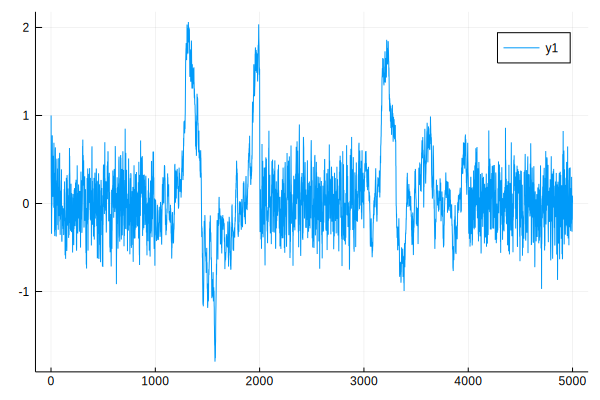

In [68]:
using Plots
plot(inputs)

In [89]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> GaussianMeanPrecision(θ, 100.0), θs)
priors_ws = map(_ -> Gamma(1.0, 1.0), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference(inputs, outputs, nmixtures, 500, 100, priors_as, priors_bs, priors_ms, priors_ws);

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

 17.447365 seconds (88.30 M allocations: 4.736 GiB, 18.19% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


In [90]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.998007   0.568882
 0.0019933  0.431118

In [91]:
minimum(mean.(mγs[end]))

19.39021459027073

In [92]:
using Plots

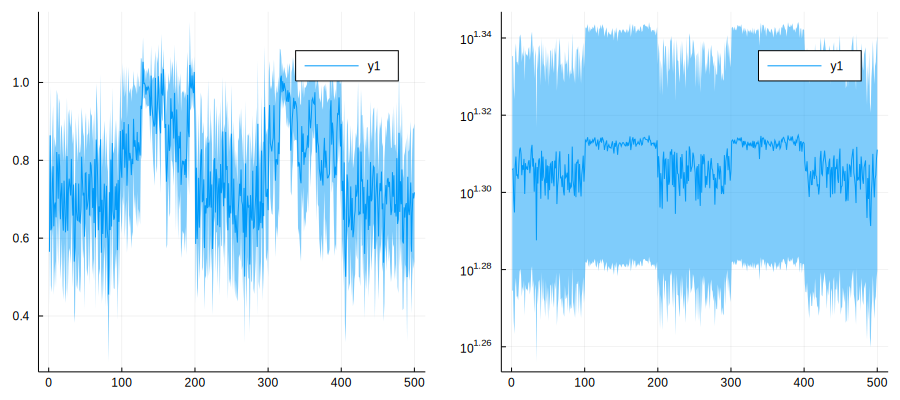

In [93]:
p1 = plot(mean.(mθs[end]), ribbon = std.(mθs[end]))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

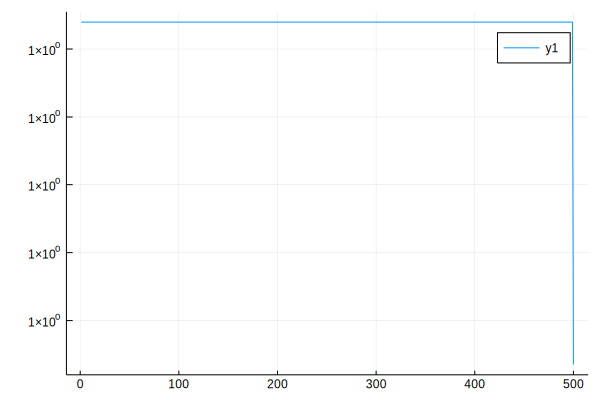

In [94]:
plot(mean.(mzs[end]))

In [95]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 ⋮
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000012177

mfe[end - 4:end] = [-1031.810561116903, -1031.8105611148349, -1031.8105611227893, -1031.8105611227438, -1031.8105611250667]


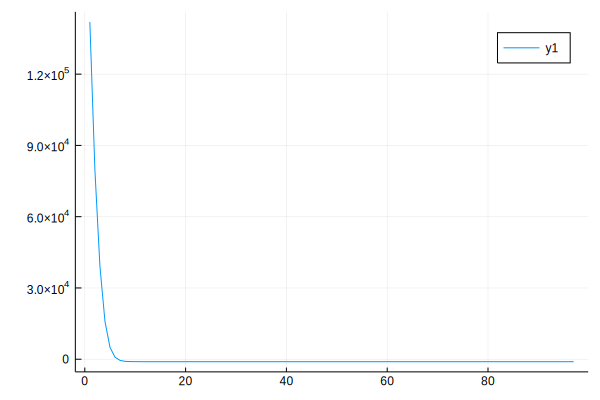

In [96]:
@show mfe[end-4:end]
plot(mfe[4:end])